**KARMANY DATASET ADDED + DATA AUGMENTED**

# Imports

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import os
import cv2

# Parameters

In [2]:
input_size = (256, 256, 3)
img_height, img_width = (256, 256)
n_classes = 1
batch_size = 32
epochs = 10

# Data Generator

In [3]:
data_dir = '../Data/train'
data_dir = pathlib.Path(data_dir)

## Augmented Data

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2, seed=5)
])

In [24]:
aug_path = '../Data/train_augmented/'

pneu_path = aug_path + 'pneumonia'
if not os.path.exists(pneu_path):
    os.makedirs(pneu_path)

normal_path = aug_path + 'normal'
if not os.path.exists(normal_path):
    os.makedirs(normal_path) 

In [25]:
batch_n = 0
for x, y in train_ds:
    batch_n += 1
    aug_x = data_augmentation(x)
    y = np.array(y)
    aug_x = np.array(aug_x)
    x = np.array(x)
    for i in range(len(y)):
        if y[i] == 0:
            path = normal_path
        else:
            path = pneu_path
        
        original_img = x[i,:,:,0]
        
        aug_img = aug_x[i,:,:,0]
        
        cv2.imwrite(path +'/' + str(batch_n) + '_' + str(i) + '_original.png', original_img)
        cv2.imwrite(path +'/' + str(batch_n) + '_' + str(i) + '_augmented.png', aug_img)  

## Augmented Data Path

In [4]:
data_dir = '../Data/train_augmented'
data_dir = pathlib.Path(data_dir)

## Preprocessed Data

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 48662 files belonging to 2 classes.
Using 38930 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 48662 files belonging to 2 classes.
Using 9732 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['normal', 'pneumonia']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
def preprocess_images(img, flag='default'):
    if flag == 'default':
        # Scale to (-1,1)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    elif flag == 'vgg':
        # convert the input images from RGB to BGR,
        #then will zero-center each color channel with respect to the ImageNet dataset,
        #without scaling.
        img = tf.keras.applications.vgg16.preprocess_input(img)
    elif flag == 'resnet':
        # convert the input images from RGB to BGR,
        #then will zero-center each color channel with respect to the ImageNet dataset,
        #without scaling.
        img = tf.keras.applications.resnet.preprocess_input(img)
    elif flag == 'nothing':
        return img
    return img

In [10]:
# VGG-16 and 19
train_ds = train_ds.map(lambda x, y: (preprocess_images(x, 'vgg'), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x, 'vgg'), y))

In [ ]:
train_ds = train_ds.map(lambda x, y: (preprocess_images(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x), y))

In [ ]:
# RESNET
train_ds = train_ds.map(lambda x, y: (preprocess_images(x, 'res'), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x, 'res'), y))

In [10]:
# MobileNet
train_ds = train_ds.map(lambda x, y: (preprocess_images(x, 'nothing'), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x, 'nothing'), y))

## Unprocessed Data

In [ ]:
train_original_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

In [ ]:
val_original_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

In [ ]:
class_names = train_original_ds.class_names
print(class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_original_ds = train_original_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_original_ds = val_original_ds.cache().prefetch(buffer_size=AUTOTUNE)

# VGG16

## Train

In [11]:
# create the base pre-trained model

base_model_vgg = tf.keras.applications.VGG16(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

In [12]:
# this is the model we will train
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)

In [ ]:
model_vgg.summary()

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_vgg.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_vgg.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_vgg.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
1217/1217 [==============================] - 152s 105ms/step - loss: 0.2137 - accuracy: 0.9240 - val_loss: 0.1427 - val_accuracy: 0.9455
Epoch 2/10
1217/1217 [==============================] - 119s 98ms/step - loss: 0.1508 - accuracy: 0.9440 - val_loss: 0.1363 - val_accuracy: 0.9513
Epoch 3/10
1217/1217 [==============================] - 120s 98ms/step - loss: 0.1332 - accuracy: 0.9511 - val_loss: 0.1328 - val_accuracy: 0.9512
Epoch 4/10
1217/1217 [==============================] - 119s 98ms/step - loss: 0.1235 - accuracy: 0.9540 - val_loss: 0.1267 - val_accuracy: 0.9514
Epoch 5/10
1217/1217 [==============================] - 123s 101ms/step - loss: 0.1107 - accuracy: 0.9585 - val_loss: 0.1207 - val_accuracy: 0.9537
Epoch 6/10
1217/1217 [==============================] - 123s 101ms/step - loss: 0.0999 - accuracy: 0.9641 - val_loss: 0.1093 - val_accuracy: 0.9578
Epoch 7/10
1217/1217 [==============================] - 118s 97ms/step - loss: 0.0912 - accuracy: 0.9666 - val_loss

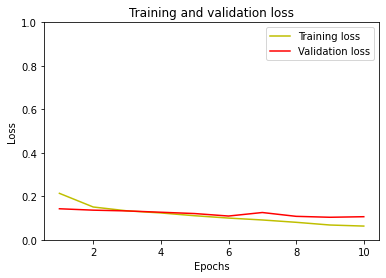

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

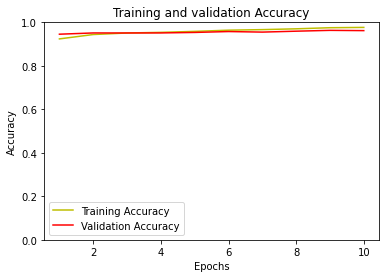

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [35]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_vgg.layers):
   print(i, layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [16]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg.layers[:11]:
   layer.trainable = False
for layer in model_vgg.layers[11:]:
   layer.trainable = True

In [17]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_vgg.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_vgg.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1217/1217 [==============================] - 170s 138ms/step - loss: 0.0657 - accuracy: 0.9767 - val_loss: 0.0619 - val_accuracy: 0.9767
Epoch 2/10
1217/1217 [==============================] - 165s 135ms/step - loss: 0.0307 - accuracy: 0.9893 - val_loss: 0.0574 - val_accuracy: 0.9810
Epoch 3/10
1217/1217 [==============================] - 168s 138ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0503 - val_accuracy: 0.9833
Epoch 4/10
1217/1217 [==============================] - 165s 136ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.0648 - val_accuracy: 0.9823
Epoch 5/10
1217/1217 [==============================] - 167s 137ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0537 - val_accuracy: 0.9855
Epoch 6/10
1217/1217 [==============================] - 166s 137ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0545 - val_accuracy: 0.9859
Epoch 7/10
1217/1217 [==============================] - 165s 136ms/step - loss: 8.2841e-04 - accuracy: 1.0000 - 

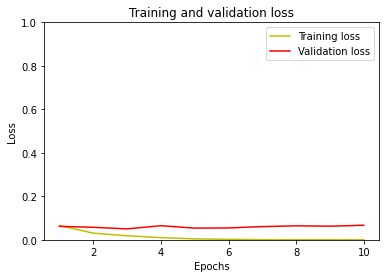

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()

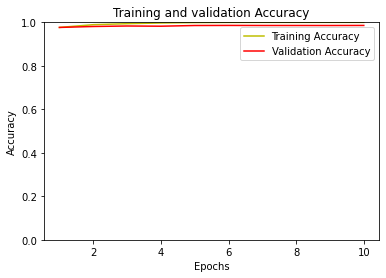

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

## Test

In [26]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (preprocess_images(x,'vgg'), y))

Found 2513 files belonging to 2 classes.


In [27]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_vgg.evaluate(test_ds)
dict(zip(model_vgg.metrics_names, result))

Evaluate
79/79 [==============================] - 7s 81ms/step - loss: 0.8615 - accuracy: 0.9053


{'loss': 0.8615303039550781, 'accuracy': 0.9052924513816833}

In [28]:
scores = []
for x_val, y_val in test_ds:
    y_pred = model_vgg.predict(x_val)
    normal = y_pred < 0.5
    y_pred[normal] = 0
    y_pred[~normal] = 1
    scores.append(accuracy_score(y_pred,y_val))

In [29]:
np.mean(np.array(scores))

0.9055053983618764

In [30]:
# Save the entire model as a SavedModel.
!mkdir -p saved_models
model_vgg.save('saved_models/vgg16_aug')

INFO:tensorflow:Assets written to: saved_models/vgg16_aug\assets


In [31]:
loaded_model = tf.keras.models.load_model('saved_models/vgg16_aug', compile=False)

#JACCARD LOSS AND DICE METRIC 
loaded_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
# Check its architecture
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

# MobileNetV3Large

## Train

In [11]:
# create the base pre-trained model

base_model_mobilenet_v3 = tf.keras.applications.MobileNetV3Large(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_mobilenet_v3.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

17620992/17605208 [==============================] - 2s 0us/step


In [12]:
# this is the model we will train
model_mobilenet_v3 = Model(inputs=base_model_mobilenet_v3.input, outputs=predictions)

In [13]:
model_mobilenet_v3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 128, 128, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 128, 128, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_mobilenet_v3.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_mobilenet_v3.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_mobilenet_v3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
1217/1217 [==============================] - 96s 64ms/step - loss: 0.1694 - accuracy: 0.9360 - val_loss: 0.1224 - val_accuracy: 0.9551
Epoch 2/10
1217/1217 [==============================] - 122s 100ms/step - loss: 0.1226 - accuracy: 0.9524 - val_loss: 0.1327 - val_accuracy: 0.9452
Epoch 3/10
1217/1217 [==============================] - 103s 85ms/step - loss: 0.1083 - accuracy: 0.9585 - val_loss: 0.1228 - val_accuracy: 0.9522
Epoch 4/10
1217/1217 [==============================] - 109s 89ms/step - loss: 0.0987 - accuracy: 0.9622 - val_loss: 0.1027 - val_accuracy: 0.9604
Epoch 5/10
1217/1217 [==============================] - 130s 107ms/step - loss: 0.0861 - accuracy: 0.9676 - val_loss: 0.0997 - val_accuracy: 0.9612
Epoch 6/10
1217/1217 [==============================] - 134s 110ms/step - loss: 0.0763 - accuracy: 0.9717 - val_loss: 0.0884 - val_accuracy: 0.9671
Epoch 7/10
1217/1217 [==============================] - 110s 90ms/step - loss: 0.0646 - accuracy: 0.9758 - val_loss:

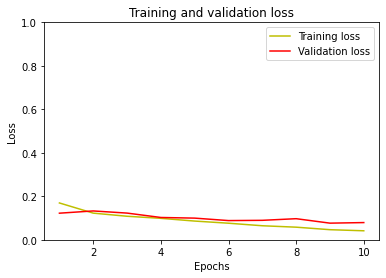

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

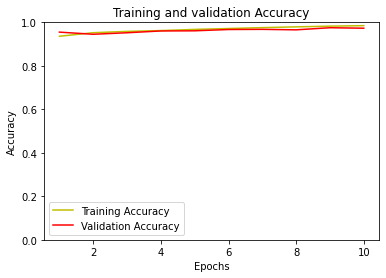

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [17]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_mobilenet_v3.layers):
   print(i, layer.name)


0 input_1
1 rescaling
2 Conv
3 Conv/BatchNorm
4 tf.__operators__.add
5 re_lu
6 tf.math.multiply
7 multiply
8 expanded_conv/depthwise
9 expanded_conv/depthwise/BatchNorm
10 re_lu_1
11 expanded_conv/project
12 expanded_conv/project/BatchNorm
13 expanded_conv/Add
14 expanded_conv_1/expand
15 expanded_conv_1/expand/BatchNorm
16 re_lu_2
17 expanded_conv_1/depthwise/pad
18 expanded_conv_1/depthwise
19 expanded_conv_1/depthwise/BatchNorm
20 re_lu_3
21 expanded_conv_1/project
22 expanded_conv_1/project/BatchNorm
23 expanded_conv_2/expand
24 expanded_conv_2/expand/BatchNorm
25 re_lu_4
26 expanded_conv_2/depthwise
27 expanded_conv_2/depthwise/BatchNorm
28 re_lu_5
29 expanded_conv_2/project
30 expanded_conv_2/project/BatchNorm
31 expanded_conv_2/Add
32 expanded_conv_3/expand
33 expanded_conv_3/expand/BatchNorm
34 re_lu_6
35 expanded_conv_3/depthwise/pad
36 expanded_conv_3/depthwise
37 expanded_conv_3/depthwise/BatchNorm
38 re_lu_7
39 expanded_conv_3/squeeze_excite/AvgPool
40 expanded_conv_3/squee

In [18]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_mobilenet_v3.layers[:221]:
   layer.trainable = False
for layer in model_mobilenet_v3.layers[221:]:
   layer.trainable = True

In [19]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_mobilenet_v3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_mobilenet_v3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1217/1217 [==============================] - 127s 101ms/step - loss: 0.1939 - accuracy: 0.9430 - val_loss: 0.1077 - val_accuracy: 0.9628
Epoch 2/10
1217/1217 [==============================] - 123s 101ms/step - loss: 0.0923 - accuracy: 0.9658 - val_loss: 0.0981 - val_accuracy: 0.9635
Epoch 3/10
1217/1217 [==============================] - 126s 103ms/step - loss: 0.0706 - accuracy: 0.9737 - val_loss: 0.0946 - val_accuracy: 0.9632
Epoch 4/10
1217/1217 [==============================] - 127s 105ms/step - loss: 0.0589 - accuracy: 0.9787 - val_loss: 0.0896 - val_accuracy: 0.9640
Epoch 5/10
1217/1217 [==============================] - 129s 106ms/step - loss: 0.0505 - accuracy: 0.9827 - val_loss: 0.0842 - val_accuracy: 0.9675
Epoch 6/10
1217/1217 [==============================] - 118s 97ms/step - loss: 0.0440 - accuracy: 0.9856 - val_loss: 0.0825 - val_accuracy: 0.9669
Epoch 7/10
1217/1217 [==============================] - 111s 91ms/step - loss: 0.0388 - accuracy: 0.9881 - val_lo

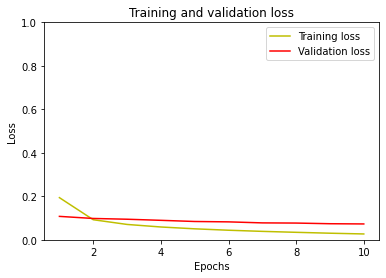

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()

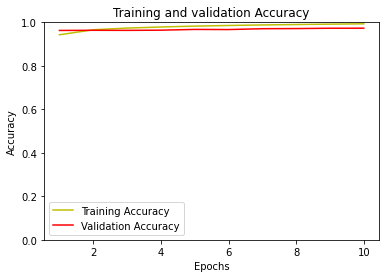

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

## Test

In [26]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (preprocess_images(x,'nothing'), y))

Found 2513 files belonging to 2 classes.


In [27]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_mobilenet_v3.evaluate(test_ds)
dict(zip(model_mobilenet_v3.metrics_names, result))

Evaluate
79/79 [==============================] - 5s 62ms/step - loss: 0.4055 - accuracy: 0.9009


{'loss': 0.4055006206035614, 'accuracy': 0.900915265083313}

# VGG19

## Train

In [11]:
# create the base pre-trained model

base_model_vgg19 = tf.keras.applications.VGG19(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

80150528/80134624 [==============================] - 8s 0us/step


In [12]:
# this is the model we will train
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=predictions)

In [ ]:
model_vgg19.summary()

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_vgg19.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_vgg19.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_vgg19.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
1217/1217 [==============================] - 166s 116ms/step - loss: 0.2215 - accuracy: 0.9254 - val_loss: 0.1420 - val_accuracy: 0.9478
Epoch 2/10
1217/1217 [==============================] - 146s 120ms/step - loss: 0.1514 - accuracy: 0.9433 - val_loss: 0.1558 - val_accuracy: 0.9416
Epoch 3/10
1217/1217 [==============================] - 143s 117ms/step - loss: 0.1356 - accuracy: 0.9509 - val_loss: 0.1294 - val_accuracy: 0.9488
Epoch 4/10
1217/1217 [==============================] - 144s 118ms/step - loss: 0.1240 - accuracy: 0.9532 - val_loss: 0.1428 - val_accuracy: 0.9444
Epoch 5/10
1217/1217 [==============================] - 143s 117ms/step - loss: 0.1157 - accuracy: 0.9565 - val_loss: 0.1116 - val_accuracy: 0.9591
Epoch 6/10
1217/1217 [==============================] - 142s 116ms/step - loss: 0.1034 - accuracy: 0.9625 - val_loss: 0.1112 - val_accuracy: 0.9576
Epoch 7/10
1217/1217 [==============================] - 142s 117ms/step - loss: 0.0959 - accuracy: 0.9641 - val_

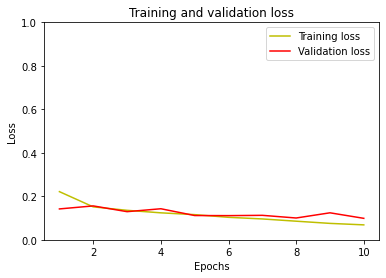

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

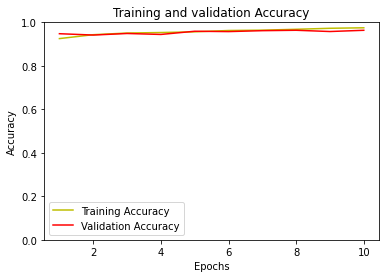

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [16]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_vgg19.layers):
   print(i, layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [19]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg19.layers[:12]:
   layer.trainable = False
for layer in model_vgg19.layers[12:]:
   layer.trainable = True

In [20]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_vgg19.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_vgg19.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1217/1217 [==============================] - 205s 167ms/step - loss: 0.0700 - accuracy: 0.9741 - val_loss: 0.0701 - val_accuracy: 0.9737
Epoch 2/10
1217/1217 [==============================] - 207s 170ms/step - loss: 0.0353 - accuracy: 0.9880 - val_loss: 0.0773 - val_accuracy: 0.9734
Epoch 3/10
1217/1217 [==============================] - 206s 169ms/step - loss: 0.0197 - accuracy: 0.9931 - val_loss: 0.0606 - val_accuracy: 0.9803
Epoch 4/10
1217/1217 [==============================] - 218s 179ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.0648 - val_accuracy: 0.9816
Epoch 5/10
1217/1217 [==============================] - 214s 176ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0532 - val_accuracy: 0.9848
Epoch 6/10
1217/1217 [==============================] - 212s 174ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0754 - val_accuracy: 0.9804
Epoch 7/10
1217/1217 [==============================] - 210s 173ms/step - loss: 0.0016 - accuracy: 0.9998 - val_

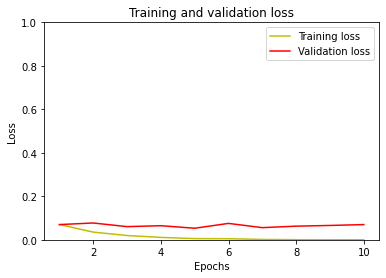

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()

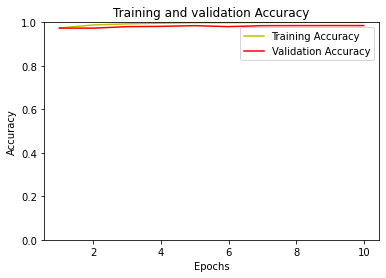

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

## Test

In [25]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (preprocess_images(x,'vgg'), y))

Found 2513 files belonging to 2 classes.


In [26]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_vgg19.evaluate(test_ds)
dict(zip(model_vgg19.metrics_names, result))

Evaluate
79/79 [==============================] - 10s 125ms/step - loss: 0.7577 - accuracy: 0.9081


{'loss': 0.7576795220375061, 'accuracy': 0.9080780148506165}